# 1)

In [136]:
import numpy as np
import matplotlib.pyplot as plt
def generate_orthogonal_signals(M, N):
    signals = np.random.normal(size=(M, N))
    orthogonal_signals = np.zeros((M, N))
    
    for i in range(M):
        orthogonal_signals[i] = signals[i]
        for j in range(i):
            orthogonal_signals[i] -= np.dot(orthogonal_signals[j], signals[i]) / np.dot(orthogonal_signals[j], orthogonal_signals[j]) * orthogonal_signals[j]
        
        # Normalize the signal
        orthogonal_signals[i] /= np.linalg.norm(orthogonal_signals[i])
    
    return orthogonal_signals

def calcPdPfa(data):
    h1s = data[data[:,1] == 1].shape[0]
    h0s = data[data[:,1] == 0].shape[0]

    currh1 = h1s
    currh0 = h0s

    pd = [1]
    pfa = [1]
    for i in data:
        if i[1] == 1:
            currh1 -= 1
        elif i[1] == 0:
            currh0 -= 1
        pd.append(currh1/h1s)
        pfa.append(currh0/h0s)
    pd.append(0)
    pfa.append(0)
    return pd,pfa  


lambda 2.1292865648573183
lambda 1.3876895967608927
lambda 2.354548868509258
lambda 2.1645895742159733
lambda 1.5552919357789876
lambda 1.9822723556666695
lambda 1.7606273554731993
lambda 1.5259988717619517
lambda 4.292475436794902
lambda 1.4905641706693935
[[1.3876896  0.        ]
 [1.49056417 0.        ]
 [1.52599887 0.        ]
 [1.55529194 0.        ]
 [1.76062736 0.        ]
 [1.98227236 1.        ]
 [2.12928656 1.        ]
 [2.16458957 1.        ]
 [2.35454887 1.        ]
 [4.29247544 1.        ]]


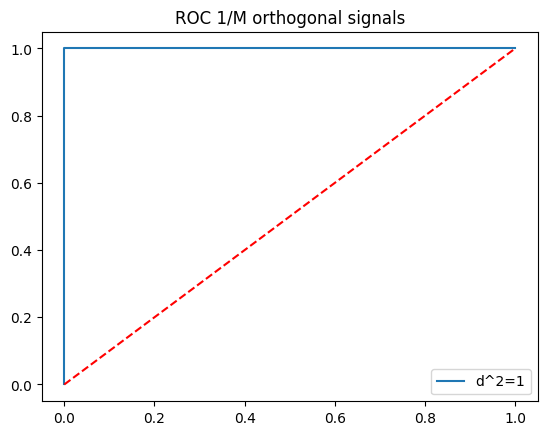

In [195]:
M = [5,1,100]
d2 = [1,2,4,16]
E = 1
signalDim = 10
n = 10


for m in M:
    fig, ax = plt.subplots()
    for d in d2:
        noise_variance = E/d

        m_orthogonal_signals = generate_orthogonal_signals(m, signalDim)
        rand_m = np.random.choice(m, n//2)
        h1 = m_orthogonal_signals[rand_m] + np.random.normal(0, noise_variance, size=(n//2, signalDim))
        h0 = np.random.normal(0, noise_variance, size=(n//2, signalDim))
        
        decisionStats = np.ndarray((n,2))

        for i, xi in enumerate(h1):
            # print("h1 xi",xi)
            # print(m_orthogonal_signals.T)
            prodSum = E/noise_variance * (xi @ m_orthogonal_signals.T)
            # print("prodsum",prodSum)
            exp = np.exp(prodSum)
            # print("exp",exp)
            lambdaa = (1/m) * np.sum(exp) 
            print("lambda",lambdaa)
            decisionStats[i,:] = np.array([lambdaa,1])

        for i, xi in enumerate(h0):
            # print("h0 xi",xi)
            prodSum = E/noise_variance * (xi @ m_orthogonal_signals.T)
            # print("prodsum",prodSum)
            exp = np.exp(prodSum)
            # print("exp",exp)
            lambdaa = (1/m) * np.sum(exp) 
            print("lambda",lambdaa)
            decisionStats[n//2+i,:] = np.array([lambdaa,0])
        decisionStats.sort(axis=0)
        print(decisionStats)
        pd,pfa = calcPdPfa(decisionStats)
        ax.plot(pfa,pd, label=f"d^2={d}") 
        ax.legend()
        ax.set_title(f"ROC 1/M orthogonal signals")
        break
    ax.plot([0, 1], [0, 1],'r--')
    plt.show()
    break



# 2) SKEP

[[2.16905566e-03 0.00000000e+00]
 [2.71093860e-02 0.00000000e+00]
 [3.10191634e-02 0.00000000e+00]
 [3.71391224e-02 0.00000000e+00]
 [5.56533516e-02 0.00000000e+00]
 [2.00705093e+01 1.00000000e+00]
 [2.02548810e+01 1.00000000e+00]
 [2.07410676e+01 1.00000000e+00]
 [2.10407151e+01 1.00000000e+00]
 [2.13547479e+01 1.00000000e+00]]


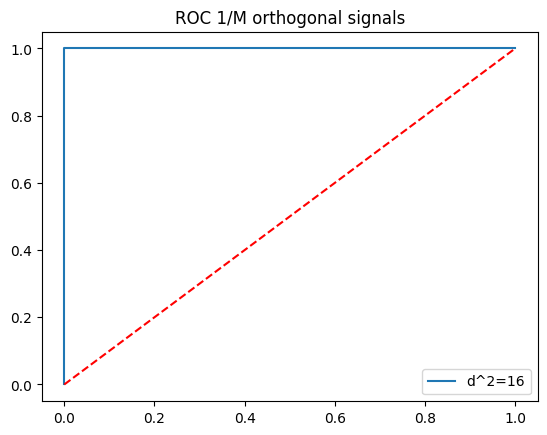

In [220]:
d2 = [16,2,4,1]
E = 1

amp = 1
freq = 10
k = 10
n = 10



unknownPhase = np.random.uniform(0, 2*np.pi)
t = np.linspace(0, 2 * np.pi, k)
signal = amp * np.sin(freq * t + unknownPhase)


fig, ax = plt.subplots()
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))

    h1_r2 = np.power(np.sum(h1*amp*np.cos(freq * t), axis=1),2) + np.power(np.sum(h1*amp*np.sin(freq * t), axis=1),2)
    decisionStats[:n//2,0] = h1_r2
    decisionStats[:n//2,1] = 1

    h0_r2 = np.power(np.sum(h0*amp*np.cos(freq * t), axis=1),2) + np.power(np.sum(h0*amp*np.sin(freq * t), axis=1),2)

    decisionStats[n//2:,0] = h0_r2
    decisionStats[n//2:,1] = 0
    decisionStats.sort(axis=0)
    print(decisionStats)

    pd,pfa = calcPdPfa(decisionStats)
    ax.plot(pfa,pd, label=f"d^2={d}") 
    break
ax.legend()
ax.set_title(f"ROC 1/M orthogonal signals")
ax.plot([0, 1], [0, 1],'r--')
plt.show()


# 3) SKEA